
# First we need to load data from the csv file and estimate AP coordinates in the same way as storyteller

The formula for finding the weight of each AP is as follows:

$$10^\frac{RSSI_{AP}}{10}$$

We can then use the weights to find the coordinates of the APs using the following formula:

$$ x_{AP} = \frac{\sum_{i=1}^{n}w_{i}x_{i}}{\sum_{i=1}^{n}w_{i}} $$

$$ y_{AP} = \frac{\sum_{i=1}^{n}w_{i}y_{i}}{\sum_{i=1}^{n}w_{i}} $$

where $x_{AP}$ and $y_{AP}$ are the coordinates of the AP, $w_{i}$ is the weight of the $i$th AP, and $x_{i}$ and $y_{i}$ are the coordinates of the $i$th AP.



In [6]:
import pandas as pd
import numpy as np

In [7]:
# read in the data
locs = ["../DATA/Test_rss_21Aug17.csv", "../DATA/Training_rss_21Aug17.csv"]
dfs = []
for loc in locs:
    dfs.append(pd.read_csv(loc, header=None))

# concatenate the dataframes
data = pd.concat(dfs, ignore_index=True)

In [8]:
# rename the columns
data.columns = ["AP_{}".format(i) for i in range(len(data.columns))]

In [9]:
# load coordinates of the scans
coords_locs = ["../DATA/Test_coordinates_21Aug17.csv", "../DATA/Training_coordinates_21Aug17.csv"]
coords_dfs = []
for loc in coords_locs:
    coords_dfs.append(pd.read_csv(loc, header=None))

# concatenate the dataframes
coords = pd.concat(coords_dfs, ignore_index=True)

In [10]:
# rename the columns
coords.columns = ["x", "y", "z"]

In [14]:
# helper functions to get ap points heard, and ap signal stengths
def get_location_indices_signals(df):
    # empty list for all ap points heard and all ap signal strengths
    all_ap_points, all_ap_signals = [], []
    for index, colname in enumerate(df):
        # ignore 100 db readings as they are filler as readMe file said
        # print("Done with AP {}".format(index-1))
        idx = df[colname].index[df[colname] != 100].to_list()
        all_ap_points.append(idx)
        all_ap_signals.append(df[colname].loc[idx])
    return all_ap_points, all_ap_signals

def get_index_coordinates(indices, coords_df):
    # get the coordinates of the aps using indices
    coordinates = coords_df.loc[indices]
    return coordinates["x"].to_numpy(), coordinates["y"].to_numpy(), coordinates["z"].to_numpy()


In [15]:
# use the formula to calculate the coordinates of the APs

def get_ap_weight(rss):
    return 100**(rss/10.0)


def approximate_ap_coordinates(x_coords, y_coords, z_coords, weights):

    # sum product of weight and coordinate
    estimated_x = np.sum(x_coords * weights)
    estimated_y = np.sum(y_coords * weights)
    estimated_z = np.sum(z_coords * weights)

    # get denominator
    sum_of_weights = weights.sum()
    
    # return tuple of coordinates
    return estimated_x/sum_of_weights , estimated_y/sum_of_weights, estimated_z/sum_of_weights

def approximate_all_ap_locations(data, coords):
    # get location and signals
    all_ap_points, all_ap_signals = get_location_indices_signals(data)
    estimated_ap_locs = []
    # check the length of them both are the same
    assert len(all_ap_points) == len(all_ap_signals)
    for i in range(len(all_ap_points)):
        # get ap indices and rss strengths
        idx, signals = all_ap_points[i], all_ap_signals[i]
        # get coordinates of the scans
        xs, ys, zs = get_index_coordinates(idx, coords)
        # get weights
        weights = np.asarray([get_ap_weight(signal) for signal in signals])
        # get estimated coordinates
        estimated_coords = approximate_ap_coordinates(xs, ys, zs, weights)
        estimated_ap_locs.append(list(estimated_coords))
    return np.asarray(estimated_ap_locs)

In [17]:
# def funciton to save the data and return the dataframe
def save_estimated_coordinates(scans, coords, save_loc):
    # get the estimated coordinates
    estimated_coords = approximate_all_ap_locations(scans, coords)
    # create dataframe
    df = pd.DataFrame(estimated_coords, columns=["x", "y", "z"])
    # save the dataframe
    df.to_csv(save_loc, index=False)
    return df

In [18]:
ap_coords_save_loc = "../raw_data/ap_coords.csv"

estimated_ap_locs = save_estimated_coordinates(data, coords, ap_coords_save_loc)

# Now that we have APs, we need to construct the AP network

- Each node is an AP
- Each node has the AP coordinates, and the received signal strength as features
- Each edge is a distance metric between each AP
- The weight of each edge is some distance metric between each AP

In [19]:
scans = data

# We want to get relative distance from strongest AP heard in each scan

In [233]:
# function to find index of strongest AP index
def get_strongest_ap_index(scan):
    # make copy of scan
    scan_copy = np.copy(scan)
    # set all 100s to -1000
    scan_copy[scan_copy == 100] = -1000
    # return index of strongest ap
    return np.argmax(scan_copy)

# function to get heard AP indices and signal strengths
def get_heard_ap_indices_and_signals(scan):
    ap_heard_indices = np.argwhere(scan !=100)
    ap_heard_signals = scan[ap_heard_indices]
    return ap_heard_indices, ap_heard_signals

# function to get the top k heard AP indices and signal strengths per scan
def get_top_k_heard_ap_indices_and_signals(scan, k=10):
    # get the heard ap indices and signals
    ap_heard_indices, ap_heard_signals = get_heard_ap_indices_and_signals(scan)
    # sort the signals
    assert len(ap_heard_indices) == len(ap_heard_signals)

    # flatten the arrays
    ap_heard_indices = ap_heard_indices.flatten()
    ap_heard_signals = ap_heard_signals.flatten()
    sorted_indices = np.argsort(ap_heard_signals)
    # print("sortred indices: {}".format(sorted_indices))
    # print("heard indices: {}".format(ap_heard_indices))
    # print("heard signals: {}".format(ap_heard_signals))
    # get the top k indices and signals
    top_k_indices = ap_heard_indices[sorted_indices[-k:]]
    top_k_signals = ap_heard_signals[sorted_indices[-k:]]
    # return the top k indices and signals
    return top_k_indices, top_k_signals

# function to get the relative coordinates wrt to the strongest ap
def get_relative_coordinates(scan, coords, scan_coords, k="none"):

    # get the index of the strongest ap
    strongest_ap_index = get_strongest_ap_index(scan)

    # get the coordinates of the strongest ap
    strongest_ap_coords = coords.loc[strongest_ap_index]

    # get the heard ap indices and signals

    # if k is none, get all the heard ap indices and signals, else get the k strongest ap indices and signals
    if k == "none":
        ap_heard_indices, ap_heard_signals = get_heard_ap_indices_and_signals(scan)
    else:
        ap_heard_indices, ap_heard_signals = get_top_k_heard_ap_indices_and_signals(scan, k=k)
    # get the coordinates of the heard aps
    ap_heard_coords = coords.loc[ap_heard_indices.flatten()].to_numpy()

    # get the relative coordinates
    relative_coords = []
    for ap_heard_coord in ap_heard_coords:
        # subtract the strongest ap coordinates from the heard ap coordinates
        ap_x, ap_y, ap_z = ap_heard_coord
        strongest_ap_x, strongest_ap_y, strongest_ap_z = strongest_ap_coords
        relative_coords.append((ap_x - strongest_ap_x, ap_y - strongest_ap_y, ap_z - strongest_ap_z))

    # get relative coordinates of the scan
    scan_x, scan_y, scan_z = scan_coords
    strongest_ap_x, strongest_ap_y, strongest_ap_z = strongest_ap_coords
    relative_scan_coords = (scan_x - strongest_ap_x, scan_y - strongest_ap_y, scan_z - strongest_ap_z)
    # return the relative coordinates
    return relative_coords, ap_heard_signals, relative_scan_coords

In [234]:
# function to get distance between two APs
def get_distance_between_aps(ap1, ap2, distance_metric="euclidean"):
    # get the coordinates of the aps
    x1, y1, z1 = ap1
    x2, y2, z2 = ap2
    # calculate the distance based on distance metric
    # distance can be euclidean, manhattan, or inverse of euclidean, default to euclidean
    if distance_metric == "euclidean":
        distance = np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)
    elif distance_metric == "manhattan":
        distance = np.abs(x1-x2) + np.abs(y1-y2) + np.abs(z1-z2)
    elif distance_metric == "inverse_euclidean":
        distance = 1/(np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)+1)
    else:
        distance = np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)

    return distance

# function to get distance between all APs
def get_distance_between_all_aps(ap_coords, distance_metric="euclidean"):

    # get the distance between each pair of aps as tuple of (ap1, ap2, distance)
    distances = []
    for i in range(len(ap_coords)):
        for j in range(i+1, len(ap_coords)):
            distances.append((i, j, get_distance_between_aps(ap_coords[i], ap_coords[j], distance_metric)))
    
    return distances

In [235]:
# create a graph using the data using networkx
import networkx as nx

# function to create a graph from the relative distance for a scan, nodes have their relative coordinates and signal strength as features
def create_graph_from_scan(ap_coords, scan, scan_coords, distance_metric="euclidean", k="none"):
    # create a graph
    G = nx.Graph()
    # get the relative coordinates and signal strengths
    relative_coords, ap_heard_signals, normalized_scan_coords = get_relative_coordinates(scan, ap_coords, scan_coords, k=k)
    # add nodes to the graph
    for i in range(len(relative_coords)):
        # get the relative coordinates and signal strength of the node
        relative_coord = relative_coords[i]
        signal_strength = ap_heard_signals[i]
        # add the node to the graph
        G.add_node(i, relative_coord=relative_coord, signal_strength=signal_strength)
    # get the distances between all the aps
    distances = get_distance_between_all_aps(relative_coords, distance_metric)
    # add the edges to the graph
    for distance in distances:
        # get the ap indices and distance
        ap1, ap2, distance = distance
        # add the edge to the graph
        G.add_edge(ap1, ap2, distance=distance)
    # return the graph
    return G, normalized_scan_coords

# function visualize the graph
def visualize_graph(G):
    from matplotlib import pyplot as plt
    # get the positions of the nodes
    pos = nx.spring_layout(G)
    # draw the nodes
    nx.draw_networkx_nodes(G, pos, node_size=100)
    # draw the edges
    nx.draw_networkx_edges(G, pos)
    # draw the labels
    nx.draw_networkx_labels(G, pos)
    # show the plot
    plt.show()


/tmp/ipykernel_202036/463262065.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(num_heard_aps_per_scan)


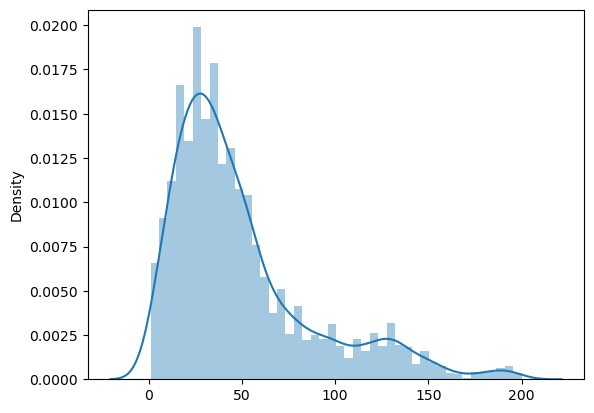

In [236]:
# check mean number of heard aps per scan
def get_mean_num_heard_aps_per_scan(data):
    # get the number of heard aps per scan
    num_heard_aps_per_scan = []
    for scan in data:
        num_heard_aps_per_scan.append(len(np.argwhere(scan != 100)))
    # return the mean
    return np.mean(num_heard_aps_per_scan)

# check the mean number of heard aps per scan
get_mean_num_heard_aps_per_scan(data.to_numpy())

# function to plot distribution of number of heard aps per scan
def plot_distribution_of_num_heard_aps_per_scan(data):
    import seaborn as sns
    import matplotlib.pyplot as plt
    # get the number of heard aps per scan
    num_heard_aps_per_scan = []
    for scan in data:
        num_heard_aps_per_scan.append(len(np.argwhere(scan != 100)))
    # plot the distribution
    sns.distplot(num_heard_aps_per_scan)
    plt.show()

# plot the distribution of number of heard aps per scan
plot_distribution_of_num_heard_aps_per_scan(data.to_numpy())

In [237]:
# # not all scans have the same number of heard aps, not all aps are relevant, so we take the top 10 heard aps per scan, if there are less than 10, we pad with 100s

# # function to get the top k heard AP indices and signal strengths per scan
# def get_top_k_heard_ap_indices_and_signals(scan, k=10):
#     # get the heard ap indices and signals
#     ap_heard_indices, ap_heard_signals = get_heard_ap_indices_and_signals(scan)
#     # sort the signals
#     sorted_indices = np.argsort(ap_heard_signals)
#     # get the top k indices and signals
#     top_k_indices = ap_heard_indices[sorted_indices[-k:]]
#     top_k_signals = ap_heard_signals[top_k_indices]
#     # return the top k indices and signals
#     return top_k_indices, top_k_signals



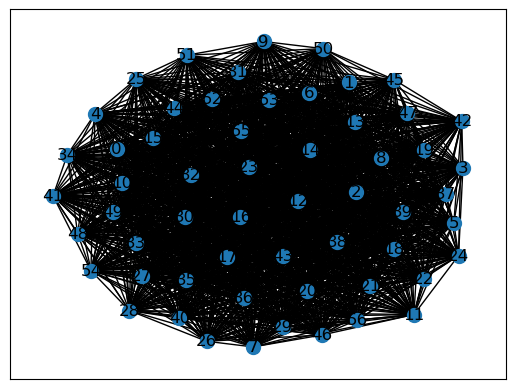

In [238]:
# test the functions
# get the scan
scan = scans.iloc[15].to_numpy()
scan_coords = coords.iloc[15].to_numpy()
# get the graph
G, relative_scan = create_graph_from_scan(estimated_ap_locs, scan, scan_coords)
# visualize the graph
visualize_graph(G)

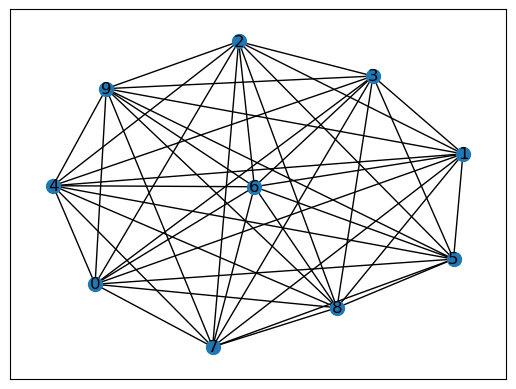

In [239]:
# test the functions
# get the scan
scan = scans.iloc[2413].to_numpy()
scan_coords = coords.iloc[2413].to_numpy()
# get the graph
G, relative_scan = create_graph_from_scan(estimated_ap_locs, scan, scan_coords, k=10)
# visualize the graph
visualize_graph(G)

In [240]:
relative_scan

(-4.366625213176462, 10.21578818506687, 1.2018700363825019e-06)

In [241]:
for node in G.nodes(data=True):
    print(node)

(0, {'relative_coord': (1.3644858866034042, -0.3474362209720141, 3.0772858142948962), 'signal_strength': -69})
(1, {'relative_coord': (5.6693022395384105, -9.515944317165143, -3.6933728309604676), 'signal_strength': -65})
(2, {'relative_coord': (0.006875927334448306, 0.25685466052372874, 4.5038448757139804e-05), 'signal_strength': -53})
(3, {'relative_coord': (-0.1500317599456764, 0.6143342405241512, 6.300191335029126e-05), 'signal_strength': -52})
(4, {'relative_coord': (-0.10696678652453784, 0.574881444021905, -1.0668875045638515e-05), 'signal_strength': -45})
(5, {'relative_coord': (-0.8996934581090841, -0.7969770324807186, -4.155897738833403e-06), 'signal_strength': -45})
(6, {'relative_coord': (0.057077525688697506, -0.3154901733540214, -4.5321953301424855e-08), 'signal_strength': -44})
(7, {'relative_coord': (-0.06056453944873397, -0.12841204801752326, 1.3605222983770204e-06), 'signal_strength': -40})
(8, {'relative_coord': (0.04250426105507188, -0.09438972904735721, -5.154568132

In [242]:
for edge in G.edges:
    print(G.edges[edge]["distance"])

12.183382249319227
3.4172625101819887
3.562031212574716
3.5334963548509988
3.846856977700466
3.3436545027777473
3.39829661956697
3.358773451818317
3.3841131253614725
11.883265845613646
12.252700114892523
12.199630013423139
11.524455178317247
11.392384527604918
11.60164420793619
11.578754052508254
11.676265969868096
0.39039937598254676
0.33778869374844506
1.3901184446744699
0.5745422624806789
0.39112485880841785
0.3530467411604747
0.2569466813133231
0.05840479873260488
1.5980588773615452
0.9526109913363491
0.7481152561507766
0.7344111848702015
0.6323891934892815
1.5844277375241924
0.9053574727758071
0.7048226050740738
0.6857590664870165
0.58474829475076
1.0710930449619975
1.072900964960323
1.175315047532853
1.201923753356812
0.22099294212982137
0.22158020334611805
0.32061174872686193
0.10853891389230108
0.14197787685601929
0.1035182745110104


In [243]:
relative_scan

(-4.366625213176462, 10.21578818506687, 1.2018700363825019e-06)

(2.705591469509727, 0.6421606044420045, -3.15707558405928)


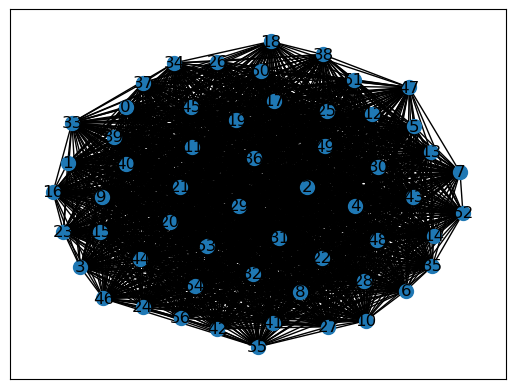

In [244]:
# test the functions
# get the scan
scan = scans.iloc[15].to_numpy()
scan_coords = coords.iloc[15].to_numpy()
# get the graph
G, relative_scan = create_graph_from_scan(estimated_ap_locs, scan, scan_coords)
# visualize the graph
print(relative_scan)
visualize_graph(G)

In [245]:
G.edges[1, 2]["distance"]

0.30022331168624883

In [246]:
# save data in raw_data folder
coords.to_csv("../raw_data/scan_coords.csv", index=False)
data.to_csv("../raw_data/scans_train.csv", index=False)

OSError: Cannot save file into a non-existent directory: '../raw_data'

In [255]:
# create a pytorch geometric dataset
import torch
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.utils.convert import from_networkx
from tqdm import tqdm
import os.path as osp
# create a dataset class





class FinlandDataset(Dataset):
    def __init__(self, root, filename, k="none", test=False, transform=None, pre_transform=None):
        """
        root: root directory of the dataset, folder is spliut into raw_dir and processed_dir
        transform: transform to apply to each data instance
        pre_transform: transform to apply to the whole dataset
        """
        self.k = k
        self.filename = filename
        self.test = test
        self.map_train = []
        self.map_test = []
        super(FinlandDataset, self).__init__(root, transform, pre_transform)
    
    @property
    def raw_file_names(self):
        """
        returns the names of the raw files in the raw_dir
        """
        return ["ap_coords.csv", "scans_train.csv", "scan_coords.csv"]
    
    @property
    def processed_file_names(self):
        """
        returns the names of the processed files in the processed_dir
        """
        return "not_implemented.pt"
    
    def download(self):
        """
        downloads the dataset
        """
        pass 
    

    def _convNxGraphToPyGData(self, ap_coords, scan, scan_coords):

        """ Helper function to convert a networkx graph to a PyG data object. """

        # get graph
        G, relative_scan_coords = create_graph_from_scan(ap_coords, scan, scan_coords, k=self.k)

        if not self.test:
            self.map_train.append((scan_coords, relative_scan_coords))
        else:
            self.map_test.append((scan_coords, relative_scan_coords))
        # convert node labels to integers
        G = nx.convert_node_labels_to_integers(G)

        # check if graph is direced or not, if yes convert to directed
        G = G.to_directed() if not nx.is_directed(G) else G

        # get edge index
        edge_index = torch.LongTensor(list(G.edges)).t().contiguous()

        # get node attributes
        node_attrs = []
        for node in G.nodes:
            node_attrs.append(list(G.nodes[node]["relative_coord"]) + [G.nodes[node]["signal_strength"]])
        
        node_attrs = np.array(node_attrs)
        # print(node_attrs)
        # get edge attrs
        edge_attrs = []
        for edge in G.edges:
            edge_attrs.append(G.edges[edge]["distance"])

        edge_attrs = np.array(edge_attrs)
        # get labels from scan coordinates
        labels = torch.tensor(np.array(list(relative_scan_coords)))

        # get data object
        data = Data(x=torch.tensor(node_attrs, dtype=torch.float), edge_index=edge_index, edge_attr=torch.tensor(edge_attrs, dtype=torch.float), y=labels)

        return data


    def get_mapping(self, idx, test=False):
        """
        returns the mapping
        """
        if not test:
            return self.map_train[idx]
        else:
            return self.map_test[idx]
        
    def process(self):
        """
        processes the dataset
        """
        dataframes = []
        for raw_path in self.raw_paths:
            dataframes.append(pd.read_csv(raw_path))
        
        self.length = len(dataframes[1])
        # get the ap coordinates
        ap_coords = dataframes[0]
        # get the scans
        if not self.test:
            scans = dataframes[1].to_numpy()
        else:
            scans = dataframes[3].to_numpy()
        # get the scan coordinates
        scan_coords = dataframes[2].to_numpy()

        # create a list of graphs

        for idx, scan in tqdm(enumerate(scans), total=len(scans)):
            # get the data object
            data = self._convNxGraphToPyGData(ap_coords, scan, scan_coords[idx])
            # save the data object
            if self.test:
                torch.sav(data, osp.join(self.processed_dir, "test_{}.pt".format(idx)))
            else:
                torch.save(data, osp.join(self.processed_dir, "train_{}.pt".format(idx)))

    def len(self):

        """
        returns the length of the dataset
        """
        return self.length

    def get(self, idx):

        """
        returns the idx-th data object
        """
        if self.test:
            data = torch.load(osp.join(self.processed_dir, "test_{}.pt".format(idx)))
        else:
            data = torch.load(osp.join(self.processed_dir, "train_{}.pt".format(idx)))
        return data
        



In [256]:
# create the dataset
finland_dataset = FinlandDataset(root="../data", filename="scans_train.csv", k=10, test=False)

Processing...
100%|██████████| 4648/4648 [00:05<00:00, 782.40it/s]
Done!


In [257]:
finland_dataset[2413]

Data(x=[10, 4], edge_index=[2, 90], edge_attr=[90], y=[3])

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 3, 4, 5, 6,
         7, 8, 9, 0, 1, 2, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 5, 6, 7, 8, 9, 0, 1, 2,
         3, 4, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 8, 9,
         0, 1, 2, 3, 4, 5, 6, 7, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8]])
